# Function Integration - Complete Pipeline

This notebook integrates the functions from notebooks 2 and 3 into a complete document processing pipeline.

## Functions Moved to src/ Modules

All functions from notebooks 2 and 3 have been moved to the `src/` folder structure:
- **OCR functions** → `src/ocr/`
- **LLM functions** → `src/llm/`
- **Storage functions** → `src/storage/`

This allows for proper code organization and reusability across the project.

> Start notebook 01 to run the docker containers

In [1]:
# Standard Library Imports
import asyncio
import json
import logging
import sys
import re
from datetime import datetime
from typing import Dict, Any, List, Protocol
from pathlib import Path

# Add project root to Python path so we can import from src/
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Force reload modules
if 'src.ocr.postprocess' in sys.modules:
    del sys.modules['src.ocr.postprocess']
if 'src.ocr.easyocr_client' in sys.modules:
    del sys.modules['src.ocr.easyocr_client']

# Import functions from notebook 02 - OCR Text Extraction
from src.ocr.easyocr_client import extract_text_bboxes_with_ocr
from src.ocr.postprocess import normalize_ocr_lines, convert_numpy_types

# Import functions from notebook 03 - LLM Field Extraction  
from src.llm.field_extractor import extract_fields_with_llm
from src.llm.client import OllamaClient, GenerativeLlm
from src.llm.config import load_document_config

# Import storage functions
from src.storage.storage import get_storage, Stage
from src.storage.blob_operations import write_ocr_results_to_bucket, read_ocr_results_from_bucket

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Upload the loan application PDF to blob storage using the storage client
document_id = "test-document-001"
filename = "loan_application.pdf"

# Load file from data folder
file_path = project_root / "data" / filename
with open(file_path, "rb") as f:
    file_data = f.read()

# Upload to blob storage using the storage client
storage_client = get_storage()
storage_client.upload_blob(
    uuid=document_id,
    stage=Stage.RAW,
    ext=".pdf",
    data=file_data,
    overwrite=True
)

blob_path = storage_client.blob_path(document_id, Stage.RAW, ".pdf")
print(f"File successfully uploaded to blob storage at: {Stage.RAW.value}/{blob_path}")

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/raw?restype=REDACTED'
Request method: 'PUT'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '5c99f540-89f3-11f0-99ae-bd13905bb0d3'
    'Authorization': 'REDACTED'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 409
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'x-ms-error-code': 'ContainerAlreadyExists'
    'x-ms-request-id': '9b8b4c78-2955-40c7-9a53-83ccc590fb09'
    'content-type': 'application/xml'
    'Date': 'Fri, 05 Sep 2025 00:57:57 GMT'
    'Connection': 'keep-alive'
    'Keep-Alive': 'REDACTED'
    'Transfer-Encoding': 'chunked'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:1000

BlobStorage initialized with multiple containers
Container 'raw' already exists
Uploaded blob: raw/test-document-001.pdf
File successfully uploaded to blob storage at: raw/test-document-001.pdf


## Configuration Loading

Load system configuration from the config file to get LLM settings.

In [3]:
def load_system_config():
    """Load system configuration from config file."""
    with open("../../config/credit-ocr-system.conf", 'r') as f:
        content = f.read()
    
    llm_match = re.search(r'generative_llm\s*\{\s*url\s*=\s*"([^"]+)"\s*model_name\s*=\s*"([^"]+)"\s*\}', content, re.DOTALL)
    if llm_match:
        return {
            'llm': {
                'url': llm_match.group(1),
                'model_name': llm_match.group(2)
            }
        }
    return {}

## Integrated Pipeline

This function combines all the processing steps into a single pipeline that processes a document from start to finish.

split of the pipeline into the components for OCR and LLM processing and visualization to keep it clean

In [4]:
async def process_document_with_ocr(document_id: str, pdf_data: bytes) -> Dict[str, Any]:
    """Process document with OCR and save results to blob storage."""
    print(f"Processing document {document_id} with OCR...")
    
    # Step 1: OCR Processing
    print("  - Extracting text with OCR...")
    ocr_results, pdf_images = extract_text_bboxes_with_ocr(pdf_data)
    print(f"  - Extracted {len(ocr_results)} text elements")
    
    # Step 2: Normalize OCR results
    print("  - Normalizing OCR results...")
    normalized_results = normalize_ocr_lines(ocr_results)
    print(f"  - Normalized to {len(normalized_results)} structured items")
    
    # Step 3: Convert NumPy types
    print("  - Converting NumPy types...")
    ocr_results_converted = convert_numpy_types(ocr_results)
    normalized_results_converted = convert_numpy_types(normalized_results)
    
    # Step 4: Prepare OCR results
    ocr_processing_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "original_lines": ocr_results_converted,
        "normalized_lines": normalized_results_converted,
        "total_elements": len(ocr_results_converted),
        "structured_items": len(normalized_results_converted)
    }
    
    # Step 5: Save OCR results to blob storage
    print("  - Saving OCR results to blob storage...")
    storage_client = get_storage()
    storage_client.upload_blob(
        uuid=document_id,
        stage=Stage.OCR,
        ext=".json",
        data=json.dumps(ocr_processing_results, indent=2, ensure_ascii=False).encode('utf-8'),
        overwrite=True
    )
    
    ocr_blob_path = storage_client.blob_path(document_id, Stage.OCR, ".json")
    print(f"  - OCR results saved to: {Stage.OCR.value}/{ocr_blob_path}")
    
    return ocr_processing_results


In [5]:
async def process_document_with_llm(document_id: str, ocr_results: Dict[str, Any]) -> Dict[str, Any]:
    """Process document with LLM field extraction and save results to blob storage."""
    print(f"Processing document {document_id} with LLM...")
    
    # Step 1: Load configuration
    print("  - Loading configuration...")
    system_config = load_system_config()
    doc_config = load_document_config("../../config/document_types.conf")
    
    # Step 2: Initialize LLM client
    print("  - Initializing LLM client...")
    llm_client = OllamaClient(
        base_url=system_config['llm']['url'],
        model_name=system_config['llm']['model_name']
    )
    
    # Step 3: Extract fields using LLM
    print("  - Extracting fields with LLM...")
    extraction_result = await extract_fields_with_llm(
        ocr_lines=ocr_results["normalized_lines"],
        doc_config=doc_config["credit_request"],
        llm_client=llm_client,
        original_ocr_lines=ocr_results["original_lines"]
    )
    
    # Step 4: Prepare LLM results
    llm_processing_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "extracted_fields": extraction_result.get("extracted_fields", {}),
        "missing_fields": extraction_result.get("missing_fields", []),
        "validation_results": extraction_result.get("validation_results", {}),
        "llm_metadata": {
            "model_used": system_config['llm']['model_name'],
            "extraction_method": "llm_assisted"
        }
    }
    
    # Step 5: Save LLM results to blob storage
    print("  - Saving LLM results to blob storage...")
    storage_client = get_storage()
    storage_client.upload_blob(
        uuid=document_id,
        stage=Stage.LLM,
        ext=".json",
        data=json.dumps(llm_processing_results, indent=2, ensure_ascii=False).encode('utf-8'),
        overwrite=True
    )
    
    llm_blob_path = storage_client.blob_path(document_id, Stage.LLM, ".json")
    print(f"  - LLM results saved to: {Stage.LLM.value}/{llm_blob_path}")
    
    return llm_processing_results


In [ ]:
# Visualization function from notebook 02
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [10]:
def visualize_ocr_results(document_id: str, ocr_results: List[Dict[str, Any]]) -> None:
    """Visualize OCR bounding boxes, text, and confidence on images and save to blob storage."""
    from io import BytesIO
    from pdf2image import convert_from_bytes
    
    # Download PDF from blob storage
    storage_client = get_storage()
    pdf_data = storage_client.download_blob(document_id, Stage.RAW, ".pdf")
    if pdf_data is None:
        raise FileNotFoundError(f"PDF not found in blob storage: {document_id}")
    
    # Convert PDF to images
    print("  - Converting PDF to images for visualization...")
    pdf_images = convert_from_bytes(pdf_data, dpi=200)
    print(f"  - Converted PDF to {len(pdf_images)} images")
    
    # Group OCR results by page
    page_to_elements: Dict[int, List[Dict[str, Any]]] = {}
    for result in ocr_results:
        page_num: int = result["page_num"]
        if page_num not in page_to_elements:
            page_to_elements[page_num] = []
        page_to_elements[page_num].append(result)
    
    # Create visualizations for each page
    for page_num, elements in page_to_elements.items():
        image = pdf_images[page_num - 1]
        fig, ax = plt.subplots(1, 1, figsize=(15, 20))
        ax.imshow(image)
        ax.set_title(f'Page {page_num} - OCR Text Extraction', fontsize=16)
        
        for element in elements:
            bbox = element['bbox']
            text = element['text']
            confidence = element['confidence']
            color = 'green' if confidence >= 0.9 else 'orange' if confidence >= 0.7 else 'red'
            
            rect = patches.Rectangle(
                (bbox['x1'], bbox['y1']),
                bbox['width'],
                bbox['height'],
                linewidth=1.5,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)
            
            display_text = text[:30] + ('...' if len(text) > 30 else '')
            label = f"{display_text} ({confidence*100:.1f}%)"
            ax.annotate(
                label,
                (bbox['x1'], bbox['y1'] - 5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.9),
                fontsize=7,
                color='black',
                ha='left',
                va='bottom'
            )
        
        legend_elements = [
            patches.Patch(color='green', label='High (≥90%)'),
            patches.Patch(color='orange', label='Med (70-89%)'),
            patches.Patch(color='red', label='Low (<70%)')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        ax.set_xlim(0, image.width)
        ax.set_ylim(image.height, 0)
        ax.axis('off')
        plt.tight_layout()
        
        # Save visualization to blob storage
        buffer = BytesIO()
        plt.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
        buffer.seek(0)
        
        # Upload to blob storage with ANNOTATED stage
        storage_client.upload_blob(
            uuid=document_id,
            stage=Stage.ANNOTATED,
            ext=f"_page_{page_num}.png",
            data=buffer.getvalue(),
            overwrite=True
        )
        
        annotated_blob_path = storage_client.blob_path(document_id, Stage.ANNOTATED, f"_page_{page_num}.png")
        print(f"  - Visualization saved to: {Stage.ANNOTATED.value}/{annotated_blob_path}")
        
        plt.show()
        plt.close()  # Close the figure to free memory
        
        high = sum(1 for e in elements if e['confidence'] >= 0.9)
        med = sum(1 for e in elements if 0.7 <= e['confidence'] < 0.9)
        low = sum(1 for e in elements if e['confidence'] < 0.7)
        avg = sum(e['confidence'] for e in elements) / len(elements) if elements else 0
        print(f"Page {page_num}: {len(elements)} elements | Avg: {avg*100:.1f}% | H:{high} M:{med} L:{low}")

In [11]:
async def integrated_pipeline(document_id: str, filename: str, blob_path: str):
    """Complete integrated pipeline combining document loading from blob storage, OCR and LLM processing."""
    
    print(f"Starting integrated pipeline for document: {document_id}")
    print(f"  - Filename: {filename}")
    print(f"  - Blob path: {blob_path}")
    
    # Step 1: Load document from blob storage
    print("Step 1: Loading document from blob storage...")
    storage_client = get_storage()
    pdf_data = storage_client.download_blob(document_id, Stage.RAW, ".pdf")
    if pdf_data is None:
        raise FileNotFoundError(f"Document not found in blob storage: {document_id}")
    print(f"  - Loaded {filename} from blob storage ({len(pdf_data)} bytes)")
    
    # Step 2: OCR Processing using modular function
    print("Step 2: OCR Processing...")
    ocr_results = await process_document_with_ocr(document_id, pdf_data)
    
    # Step 3: LLM Processing using modular function
    print("Step 3: LLM Field Extraction...")
    llm_results = await process_document_with_llm(document_id, ocr_results)
    
    # Step 4: Visualize OCR results
    print("Step 4: Visualizing OCR results...")
    visualize_ocr_results(document_id, ocr_results["original_lines"])
    
    # Step 5: Prepare final results
    final_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "document_info": {
            "filename": filename,
            "file_size": len(pdf_data),
            "source": "blob_storage",
            "blob_path": blob_path
        },
        "ocr_results": ocr_results,
        "llm_results": llm_results,
        "status": "completed"
    }
    
    print("Step 5: Pipeline completed successfully!")
    print(f"  - Extracted {len(llm_results.get('extracted_fields', {}))} fields")
    print(f"  - Missing {len(llm_results.get('missing_fields', []))} fields")
    
    return final_results

## Run the Pipeline

Execute the complete integrated pipeline to process the loan application document.

In [12]:
# Use the document that was uploaded to blob storage
document_id = "test-document-001"
filename = "loan_application.pdf"
blob_path = f"{Stage.RAW.value}/{document_id}.pdf"

## Modular Processing Functions

Separate functions for OCR and LLM processing that can be reused and tested independently.


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/raw/test-document-001.pdf'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '1eb28016-89f4-11f0-99ae-bd13905bb0d3'
    'Authorization': 'REDACTED'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'last-modified': 'Fri, 05 Sep 2025 00:57:57 GMT'
    'x-ms-creation-time': 'REDACTED'
    'content-length': '147568'
    'content-type': 'application/octet-stream'
    'content-range': 'REDACTED'
    'etag': '"0x1E92AB0DEFBEBF0"'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    

Starting integrated pipeline for document: test-document-001
  - Filename: loan_application.pdf
  - Blob path: raw/test-document-001.pdf
Step 1: Loading document from blob storage...
Downloaded blob: raw/test-document-001.pdf
  - Loaded loan_application.pdf from blob storage (147568 bytes)
Step 2: OCR Processing...
Processing document test-document-001 with OCR...
  - Extracting text with OCR...


INFO:src.ocr.easyocr_client:Processing PDF from bytes (size: 147568 bytes)
INFO:src.ocr.easyocr_client:Successfully converted PDF to 1 images
/Users/markuskuehnle/Documents/projects/credit-ocr-system/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/ocr/test-document-001.json'
Request method: 'PUT'
Request headers:
    'Content-Length': '24171'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '20497894-89f4-11f0-99ae-bd13905bb0d3'
    'Authorization': 'REDACTED'
A body 

  - Extracted 62 text elements
  - Normalizing OCR results...
  - Normalized to 26 structured items
  - Converting NumPy types...
  - Saving OCR results to blob storage...
Uploaded blob: ocr/test-document-001.json
  - OCR results saved to: ocr/test-document-001.json
Step 3: LLM Field Extraction...
Processing document test-document-001 with LLM...
  - Loading configuration...
  - Initializing LLM client...
  - Extracting fields with LLM...


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/llm/test-document-001.json'
Request method: 'PUT'
Request headers:
    'Content-Length': '6152'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '3b6e14b8-89f4-11f0-99ae-bd13905bb0d3'
    'Authorization': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 201
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'etag': '"0x23610A4D72A42C0"'
    'last-modified': 'Fri, 05 Sep 2025 01:04:11 GMT'
    'content-md5': 'REDACTED'
    'x-ms-client-request-id': '3b6e14b8-89f4-11f0-99ae-bd13905bb0d3'
    'x-ms-request-id': 'a69c3c26-ad85-42d7-8a6e-999b16eab25a'
    'x-ms-version

  - Saving LLM results to blob storage...
Uploaded blob: llm/test-document-001.json
  - LLM results saved to: llm/test-document-001.json
Step 4: Visualizing OCR results...
Downloaded blob: raw/test-document-001.pdf
  - Converting PDF to images for visualization...
  - Converted PDF to 1 images


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/annotated?restype=REDACTED'
Request method: 'PUT'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '3bd70fa4-89f4-11f0-99ae-bd13905bb0d3'
    'Authorization': 'REDACTED'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 409
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'x-ms-error-code': 'ContainerAlreadyExists'
    'x-ms-request-id': '22e28fb5-6f5e-4d67-a43e-763b4ce726a8'
    'content-type': 'application/xml'
    'Date': 'Fri, 05 Sep 2025 01:04:11 GMT'
    'Connection': 'keep-alive'
    'Keep-Alive': 'REDACTED'
    'Transfer-Encoding': 'chunked'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.

Container 'annotated' already exists
Uploaded blob: annotated/test-document-001._page_1.png
  - Visualization saved to: annotated/test-document-001._page_1.png


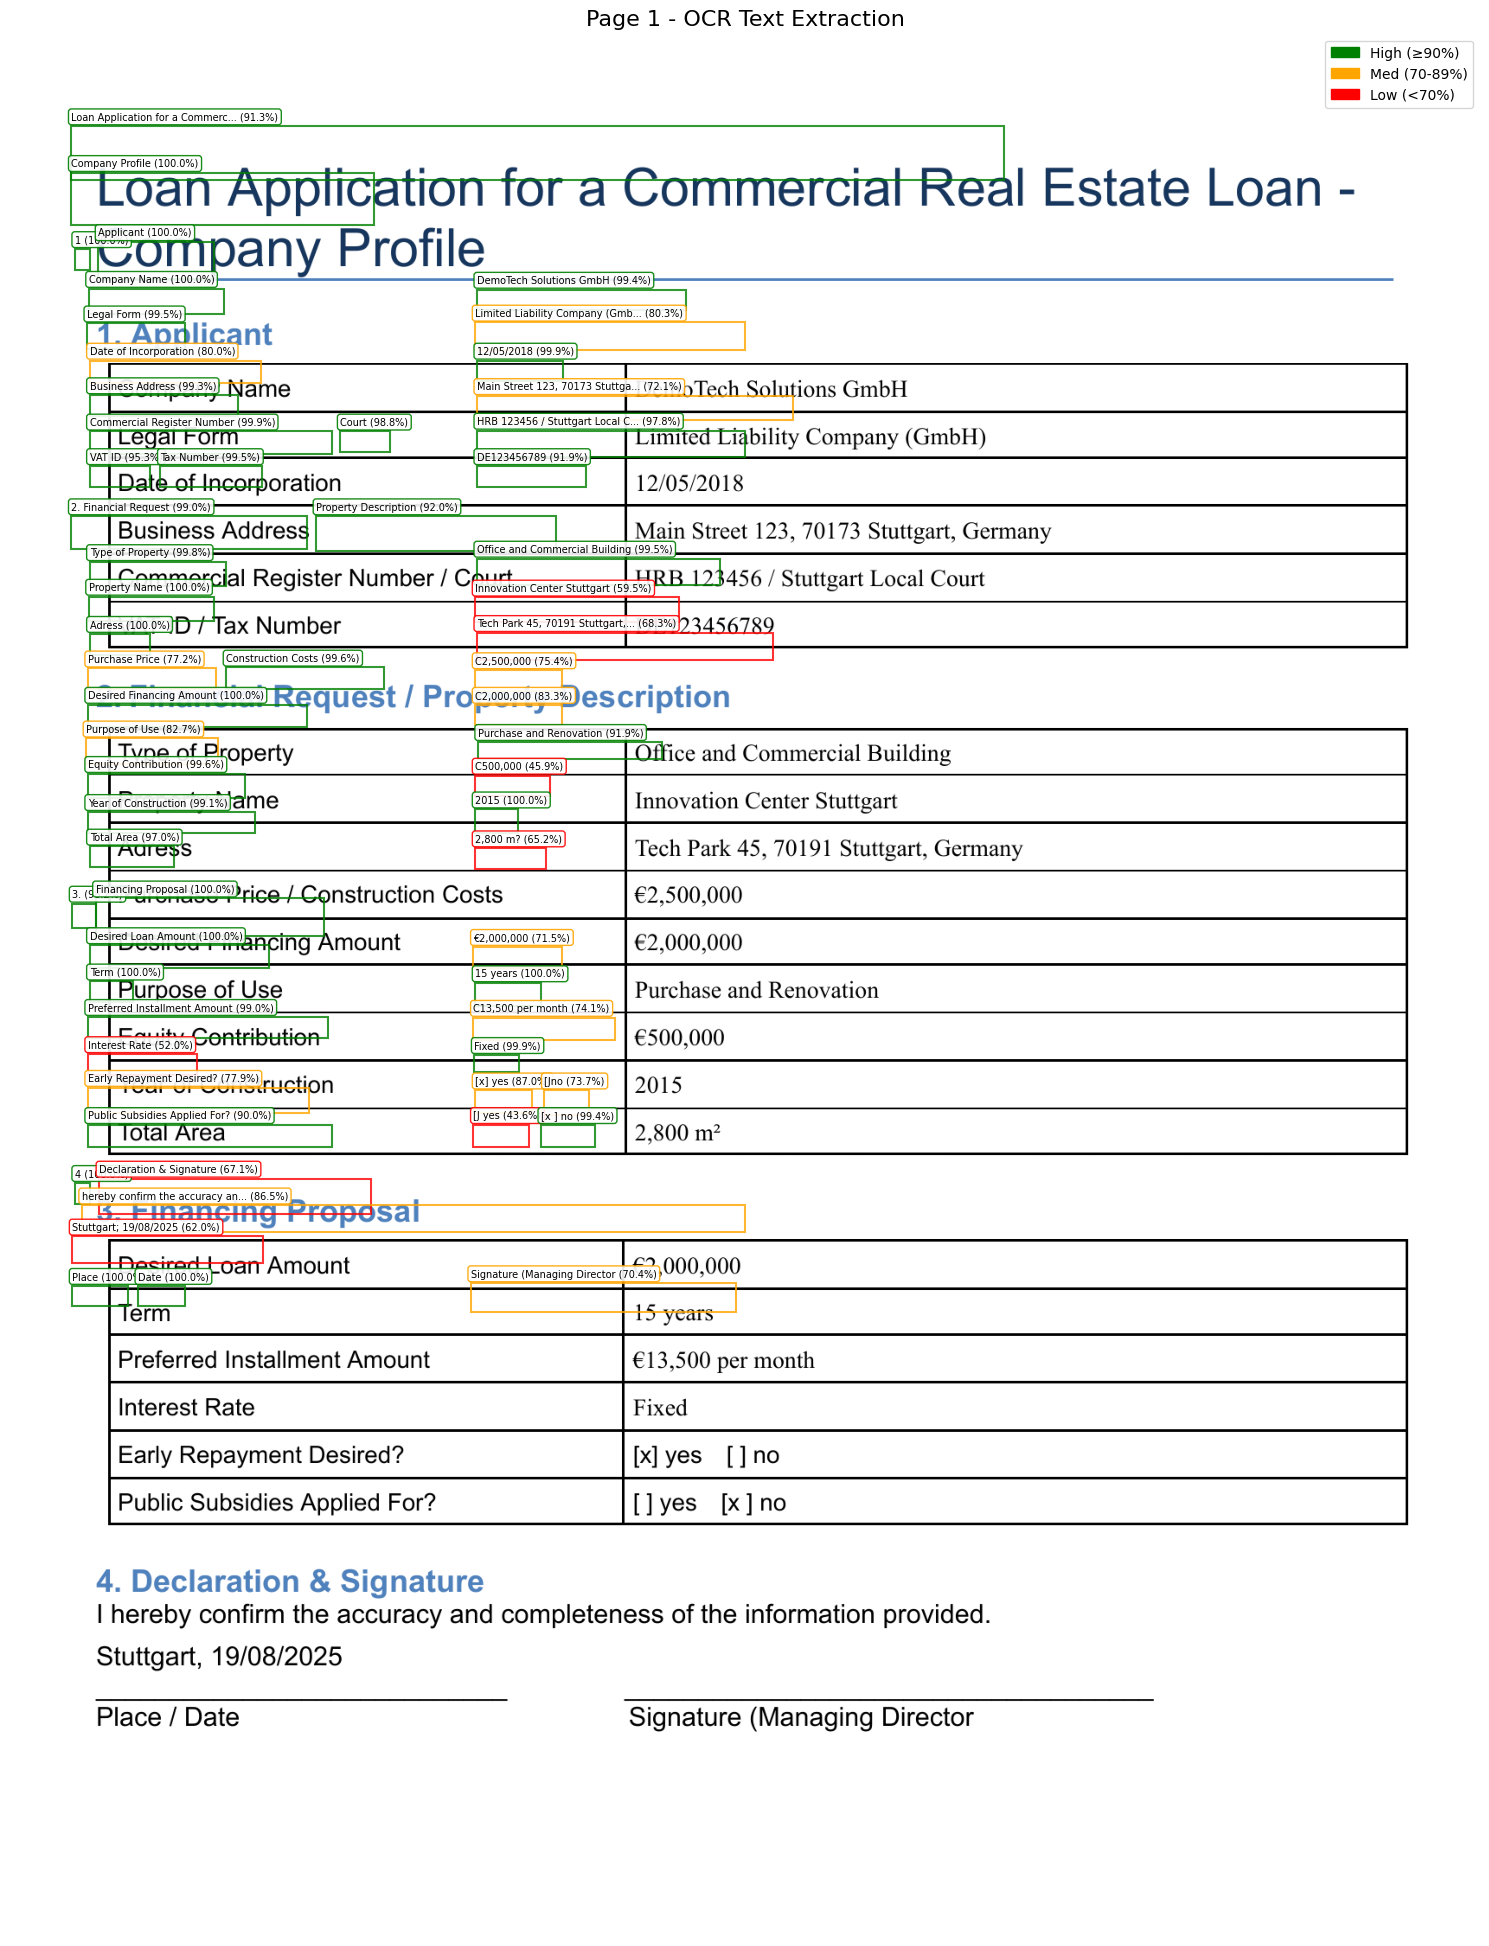

Page 1: 62 elements | Avg: 88.6% | H:40 M:14 L:8
Step 5: Pipeline completed successfully!
  - Extracted 21 fields
  - Missing 0 fields
PIPELINE COMPLETED SUCCESSFULLY!


In [13]:
results = await integrated_pipeline(document_id, filename, blob_path)
print("=" * 50)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 50)